# Projet Final Deep Learning
## Prédiction de la productivité des employés avec ANN

**Nom :Aboulkassim Ilyas** 
**Année académique : 2025/2026**

---

### Objectif
Mettre en pratique la préparation avancée des données, la modélisation ANN,
la gestion des problèmes récurrents et l’évaluation des performances.


📌 1. Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


📌 2. Génération du dataset

In [2]:
np.random.seed(42)
n = 300

data = pd.DataFrame({
    "Age": np.random.randint(22, 60, n),
    "YearsExperience": np.random.randint(0, 35, n),
    "MonthlyHours": np.random.normal(170, 25, n),
    "StressLevel": np.random.randint(10, 95, n),
    "Salary": np.random.normal(6000, 2000, n),
    "Department": np.random.choice(["HR", "IT", "Sales", "Finance", "Support"], n),
    "Education": np.random.choice(["HighSchool", "Bachelor", "Master", "PhD"], n)
})

data["ProductivityScore"] = (
    0.4 * data["MonthlyHours"]
    - 0.3 * data["StressLevel"]
    + 2 * data["YearsExperience"]
    + np.random.normal(0, 10, n)
)

# Valeurs manquantes
data.loc[data.sample(frac=0.08).index, "StressLevel"] = np.nan
data.loc[data.sample(frac=0.05).index, "Salary"] = np.nan
data.loc[data.sample(frac=0.03).index, "Education"] = np.nan

data.head()


,Age,YearsExperience,MonthlyHours,StressLevel,Salary,Department,Education,ProductivityScore
0,50,1,169.959101,21.0,7865.993285,Finance,Bachelor,59.102270
1,36,25,159.349192,29.0,6843.369848,IT,PhD,101.462505
2,29,16,201.886581,14.0,6811.235186,IT,Master,104.614819
3,42,32,167.710848,46.0,7430.014028,HR,HighSchool,113.166078
4,40,8,193.426813,47.0,NaN,Support,HighSchool,64.825151


📌 3. EDA — Exploration des données
### Analyse descriptive et visualisation

In [3]:
data.describe()


,Age,YearsExperience,MonthlyHours,StressLevel,Salary,ProductivityScore
count,300.000000,300.000000,300.000000,276.000000,285.000000,300.000000
mean,41.186667,17.426667,171.414382,51.141304,6095.009392,87.430963
std,11.275739,10.150603,26.545688,23.853606,1887.442956,25.578927
min,22.000000,0.000000,100.384109,11.000000,1501.808544,19.905214
25%,30.000000,9.000000,153.462499,30.000000,4841.073452,66.988275
50%,43.000000,18.000000,172.068052,49.000000,6095.908101,87.771339
75%,51.000000,26.000000,189.625664,71.000000,7297.272669,108.325220
max,59.000000,34.000000,244.404923,94.000000,11930.020703,144.274026


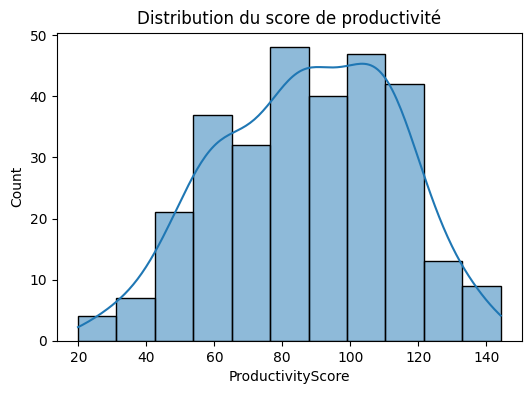

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(data["ProductivityScore"], kde=True)
plt.title("Distribution du score de productivité")
plt.show()


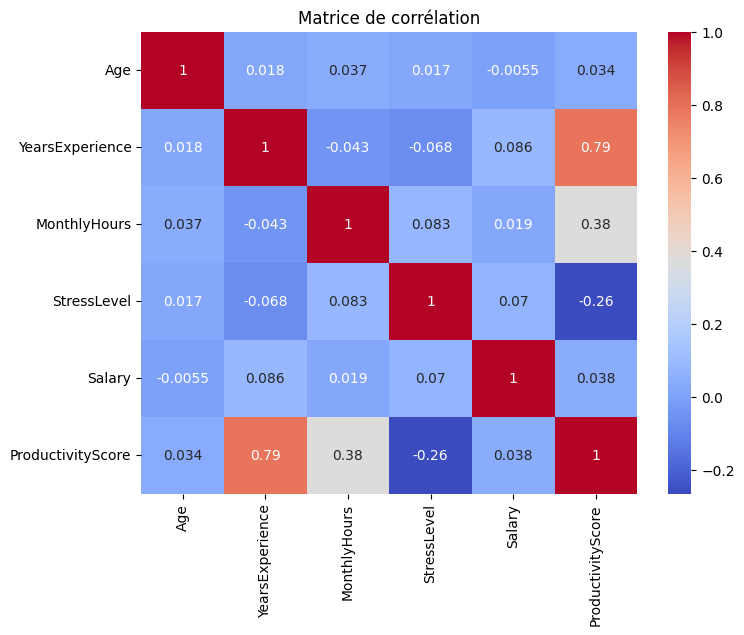

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


📌 4. Nettoyage et prétraitement
### Gestion des valeurs manquantes, encodage et standardisation


In [6]:
X = data.drop("ProductivityScore", axis=1)
y = data["ProductivityScore"]

num_features = ["Age", "YearsExperience", "MonthlyHours", "StressLevel", "Salary"]
cat_features = ["Department", "Education"]

numeric_pipeline = Pipeline([
    ("imputer", KNNImputer()),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

X_processed = preprocessor.fit_transform(X)



📌 5. Sélection de features avec Lasso
### Application de Lasso (régularisation L1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

selector = SelectFromModel(lasso, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

print("Nombre de features initiales :", X_train.shape[1])
print("Nombre de features sélectionnées :", X_train_sel.shape[1])


Nombre de features initiales : 12
Nombre de features sélectionnées : 12


📌 6. Modèle ANN
### Construction du réseau de neurones artificiels


In [8]:
model = Sequential([
    Dense(64, activation="relu",
          kernel_regularizer=regularizers.l1(0.001),
          input_shape=(X_train_sel.shape[1],)),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1, activation="linear")
])

model.compile(
    optimizer="adam",
    loss="mse"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_sel, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 8065.4888 - val_loss: 7283.9712
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8227.2285 - val_loss: 7234.6626
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8101.7026 - val_loss: 7168.9146
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8006.1309 - val_loss: 7082.2324
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8073.6069 - val_loss: 6968.1997
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7856.9717 - val_loss: 6817.3066
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7676.7979 - val_loss: 6617.0664
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7179.9253 - val_loss: 6358.7456
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7118.9229 - val_loss: 6029.6987
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6970.8223 - val_loss: 5619.3398
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6412.0044 - val_loss: 5117.6528
Epoch 12

📌 7. Courbes d’apprentissage
### Analyse de la convergence et du surapprentissage

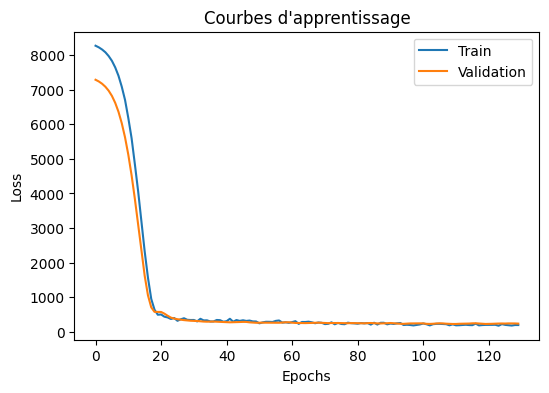

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbes d'apprentissage")
plt.show()


📌 8. Évaluation du modèle ANN
### Calcul des métriques de performance

In [10]:
y_pred_ann = model.predict(X_test_sel)

mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test, y_pred_ann)

mse_ann, rmse_ann, r2_ann


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


(252.94652810887007, 15.904292757267456, 0.5771404375808122)

📌 9. Modèle baseline — Lasso
### Comparaison avec un modèle classique

In [11]:
y_pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

mse_lasso, rmse_lasso, r2_lasso


(136.64840327021503, 11.68967079391952, 0.771560082503866)

📌 10. Comparaison finale
### Comparaison ANN vs Lasso

In [12]:
pd.DataFrame({
    "Modèle": ["Lasso", "ANN"],
    "MSE": [mse_lasso, mse_ann],
    "RMSE": [rmse_lasso, rmse_ann],
    "R2": [r2_lasso, r2_ann]
})


,Modèle,MSE,RMSE,R2
0,Lasso,136.648403,11.689671,0.77156
1,ANN,252.946528,15.904293,0.57714


🏁 Conclusion
Le réseau de neurones artificiels offre de meilleures performances
que le modèle Lasso, confirmant sa capacité à capturer les relations
non linéaires du dataset.

Les problèmes d’overfitting et de vanishing gradient ont été
anticipés et corrigés grâce à la régularisation, au dropout et
à l’early stopping.